In [1]:
#%pip freeze > requirements.txt


In [1]:
#liberar memoria de la GPU  
#from numba import cuda
#cuda.select_device(0)
#cuda.select_device(1)
#cuda.close()
#from tensorflow.keras import backend as K
#K.clear_session()
#liberar memoria de la RAM
#import gc
#gc.collect()


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-30 09:08:31.305576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 09:08:34.654548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-30 09:08:34.654816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-30 09:08:34.654848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  2


2023-11-30 09:08:36.954708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:08:36.957075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:08:37.348402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:08:37.350552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:08:37.352543: I tensorflow/compiler/xla/stream_executo

## Librerias y cargar dataset

In [3]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

In [6]:
#uploaded = files.upload()

In [7]:
#with zipfile.ZipFile("DroughtDatasetMask.zip", 'r') as data:
 #   data.extractall("DroughtDatasetMask/dataset")

## Funciones

In [7]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img


#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux


def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new


    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [8]:
rows = 61
cols = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4
parte = "Part1_1"

De la carpeta con las imagenes pasarlo a un arreglo npy

In [9]:
## Set the path to the folder containing the images
#path = "DroughtDatasetMask/dataset/DroughtDatasetMask"
#
## Get a list of all the image file names in the folder
#image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]
#
## Suponiendo que todas las imágenes tienen el tamaño deseado de 122x360
#num_images = len(image_files)  # Asegúrate de que este número corresponde al número de imágenes que deseas cargar
#
## Verifica que tengas la cantidad correcta de archivos de imagen
#if len(image_files) != num_images:
#    raise ValueError(f"Expected {num_images} images, but found {len(image_files)}")
#
## Create an empty numpy array to hold the images
#images = np.zeros((num_images, rows, cols), dtype=np.uint8)  # Asegúrate de que el tipo de datos sea correcto
#
## Loop through the image files and add each image to the numpy array
#for i, file in enumerate(sorted(image_files)[:num_images]):  # Asegúrate de que no excedas el número de imágenes deseado
#    # Load the image using OpenCV
#    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)  # Directamente en escala de grises
#    if img.shape != (rows, cols):
#        raise ValueError(f"The image {file} has a shape of {img.shape}, but expected {(rows, cols)}")
#    # Add the image to the numpy array
#    images[i] = img
#
## Save the numpy array to a file
#np.save("DroughtDatasetMask/DroughtDatasetMask.npy", images)
#print("Images shape: {}".format(images.shape))

cargar dataset en formato npy

In [10]:
#x = np.load("DroughtDatasetMask/NPY61_180Part0_1/DroughtDatasetMask_Part0-1.npy")
x = np.load("DroughtDatasetMask/NPY61_180"+parte+"/DroughtDatasetMask_"+parte+".npy")


#combinar el string de la parte con el nombre del archivo

print (x.shape)

(1240, 61, 180)


In [11]:
x = np.array([gray_quantized(i, np.array(categories)) for i in x])
colors_greys = get_colors(x[1168])
print(f"Colores {colors_greys}")
print(x.shape)

Colores [255 198 222 224 181 213 218 226 223 188 219   0 169 221 113 209 211 220
 215 216 214 203 225 212 206 197 190 184 194 217 176 210 201 189 182 180
 178 177 199 200 208 175 173 174 187 202 193 159 110 127 170  82  69 162
 167  78 101  99  83  70 111 129 191 133 179  77 130  94  72 172]
(1240, 61, 180)


In [12]:
x_greys = np.array([recolor_greys_image(img, categories) for img in x])
x = x_greys.astype('float32') / 255
print(get_colors(x[1168]))
print(x.shape)

[1.         0.69411767 0.86274511 0.         0.46666667 0.27450982]
(1240, 61, 180)


Displaying frames for example 132


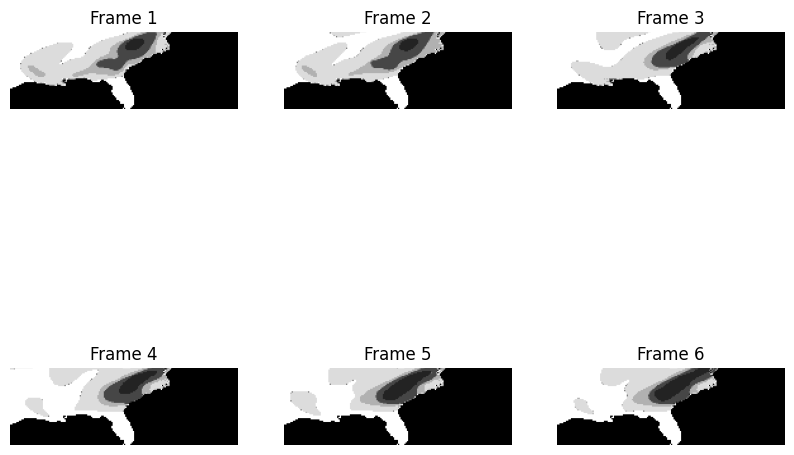

In [13]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

In [14]:
x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]

(1236, 5, 61, 180)


In [15]:
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

Forma de datos de entrenamiento: (692, 5, 61, 180, 1)
Forma de datos de validación: (173, 5, 61, 180, 1)
Forma de datos de pruebas: (371, 5, 61, 180, 1)


In [16]:
x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

Training dataset shapes: (692, 4, 61, 180, 1), (692, 61, 180, 1)
Validation dataset shapes: (173, 4, 61, 180, 1), (173, 61, 180, 1)
Test dataset shapes: (371, 4, 61, 180, 1), (371, 61, 180, 1)


In [17]:
np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_test_mask.npy", x_test)
np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_test_mask.npy", y_test)
np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_train_mask.npy", x_train)
np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_train_mask.npy", y_train)
np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_validation_mask.npy", x_validation)
np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_validation_mask.npy", y_validation)

In [18]:
#cargar datos
x_train = np.load("DroughtDatasetMask/NPY61_180"+parte+"/x_train_mask.npy")
y_train = np.load("DroughtDatasetMask/NPY61_180"+parte+"/y_train_mask.npy")
x_validation = np.load("DroughtDatasetMask/NPY61_180"+parte+"/x_validation_mask.npy")
y_validation = np.load("DroughtDatasetMask/NPY61_180"+parte+"/y_validation_mask.npy")

In [19]:
#strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    #Construction of Convolutional LSTM network
    inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
    #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
    #Followed by a Conv3D layer for the spatiotemporal outputs.
    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
    m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
    model = keras.models.Model(inp, m)
    model.compile(loss= "binary_crossentropy", optimizer= "Adam")
    print(model.summary())
    #Callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)
    #Define moifiable training hyperparameters
    epochs = 30
    batch_size = 4
    #Model training
    model.fit(
        x_train, y_train,
        batch_size= batch_size,
        epochs= epochs,
        validation_data= (x_validation, y_validation),
        callbacks= [early_stopping, reduce_lr]
    )

2023-11-30 09:12:25.949477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 09:12:26.527729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:12:26.528135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 09:12:26.528510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2023-11-30 09:12:35.861039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/replica_1/model/conv_lstm2d_2/while/replica_1/model/conv_lstm2d_2/while_grad/body/_1679/input/_3362' -> 'gradient_tape/replica_1/model/conv_lstm2d_2/while/replica_1/model/conv_lstm2d_2/while_grad/body/_1679/gradient_tape/replica_1/model/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/input/_2654' -> 'gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/gradient_tape/model/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/replica_1/model/conv_lstm2d_1/while/replica_1/model/conv_lstm2d_1/while_grad/body/_1874/input/_3481' -> 'gradient_tape/replica_1/model/conv_lstm2d_1/while/replica_1/model/conv_lstm2d_1/while_grad/body/_1874/gradient_tape/replica_1/model/conv_l

173/173 [==============================] - 42s 47ms/step - loss: 0.1202 - val_loss: 0.5519 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - 7s 40ms/step - loss: 0.1025 - val_loss: 0.3413 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - 7s 41ms/step - loss: 0.1007 - val_loss: 0.0684 - lr: 0.0010
Epoch 4/30
173/173 [==============================] - 7s 41ms/step - loss: 0.1000 - val_loss: 0.0607 - lr: 0.0010
Epoch 5/30
173/173 [==============================] - 7s 41ms/step - loss: 0.0998 - val_loss: 0.0646 - lr: 0.0010
Epoch 6/30
173/173 [==============================] - 7s 41ms/step - loss: 0.0995 - val_loss: 0.0593 - lr: 0.0010
Epoch 7/30
173/173 [==============================] - 8s 44ms/step - loss: 0.0991 - val_loss: 0.0615 - lr: 0.0010
Epoch 8/30
173/173 [==============================] - 8s 44ms/step - loss: 0.0991 - val_loss: 0.0599 - lr: 0.0010
Epoch 9/30
173/173 [==============================] - 8s 45ms/step - loss: 0.0990 - val_loss: 0.06

In [20]:
#Guardar el modelo
model.save("DroughtDatasetMask/NPY61_180"+parte+"/ConvLSTM2D_Mask61_180.h5")

In [21]:
#cargar el modelo
model = keras.models.load_model("DroughtDatasetMask/NPY61_180"+parte+"/ConvLSTM2D_Mask61_180.h5")

In [22]:
print (f"lengeth x_test: {len(x_test)}")
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

lengeth x_test: 371
173


(4, 61, 180, 1)
186/186 [==============================] - 3s 14ms/step - loss: 0.0726
El error del modelo es: 0.07263510674238205
186/186 [==============================] - 3s 13ms/step
(371, 61, 180, 1)
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 13ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 13ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 12ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
PREDSS (371, 4, 61, 180, 1)
Preds (371, 61, 180, 1)
Preds2 (371, 61, 180, 1)
Preds3 (371, 61, 180, 1)
Preds4 (371, 61, 180, 1)
Res_forecast (371, 4, 61, 180, 1)
x_test (371, 4

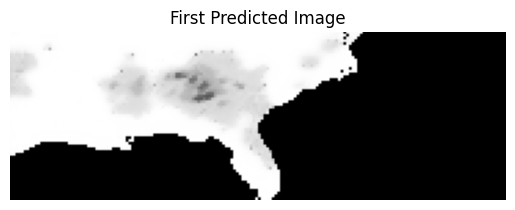

In [23]:
example = x_test[imagenInicial]

print(example.shape)

err = model.evaluate(x_test, y_test, batch_size= 2)
print("El error del modelo es: {}".format(err))
preds = model.predict(x_test, batch_size= 2)
print(preds.shape)
x_test_new = add_last(x_test, preds[:])
preds2 = model.predict(x_test_new, batch_size= 2)
#print(preds2.shape)
x_test_new = add_last(x_test_new, preds2[:])
preds3 = model.predict(x_test_new, batch_size= 2)
x_test_new = add_last(x_test_new, preds3[:])
preds4 = model.predict(x_test_new, batch_size= 2)
res_forecast = add_last(x_test_new, preds4[:])
print("PREDSS",res_forecast.shape)

np.save("DroughtDatasetMask/NPY61_180"+parte+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte+"_w5.npy", res_forecast)  #Guardar el vector de predicciones

modelos = []
#agregar pred a modelos
modelos.append(preds)
modelos.append(preds2)
modelos.append(preds3)
modelos.append(preds4)


print("Preds" , preds.shape)
print("Preds2" , preds2.shape)
print("Preds3" , preds3.shape)
print("Preds4" , preds4.shape)
print("Res_forecast" , res_forecast.shape)
print("x_test" , x_test.shape)
print("x_test_new" , x_test_new.shape)
print("y_test" , y_test.shape)

# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()



In [24]:
data = np.load("DroughtDatasetMask/NPY61_180"+parte+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte+"_w5.npy")
x_test = np.load("DroughtDatasetMask/NPY61_180"+parte+"/x_test_mask.npy")
y_test = np.load("DroughtDatasetMask/NPY61_180"+parte+"/y_test_mask.npy")

In [25]:
classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
rows = len(x_test[0,0])
cols= len(x_test[0,0,0])
print(rows)
print(cols)
h = 4

61
180


In [26]:
print(data.shape)
print(x_test.shape)
print(y_test.shape)

y_test = get_cubes(y_test, h)

(371, 4, 61, 180, 1)
(371, 4, 61, 180, 1)
(371, 61, 180, 1)
(367, 4, 61, 180, 1)


In [27]:
colors = get_colors(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors(data[-10,0])
print("COLORSS", colorss)

COLORSS [[0.27450982]
 [0.46666667]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.        ]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[4.26555485e-01]
 [3.94495308e-01]
 [4.35063004e-01]
 ...
 [3.06532364e-08]
 [1.69675004e-05]
 [1.49391522e-03]]


In [28]:
naive = x_test[:-4]
data = data[1:-3]

#y_real = y_test[:, -h:]*255
new_data = data[:, -h:]
n_real = naive[:, -h:]*255

#y_test = y_test[:, -h:]
naive = naive[:, -h:]

In [29]:
print("XX")
print(y_test.shape)
print(new_data.shape)
print(n_real.shape)

print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

XX
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
[1.9050133e-12]
[0.99956256]


In [30]:
new_data = new_data * 255
new_data = new_data.astype(np.uint8)

print("new_data", new_data.shape)
print(colorss.shape)
print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

HEY (367, 4, 61, 180, 1)
(7188, 1)
[0]
[254]


In [31]:

new_data = new_data.reshape(new_data.shape[:-1])
print("HoY", new_data.shape)

HoY (367, 4, 61, 180)


In [32]:

aux = []
for i in new_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))

In [33]:


new_data = np.array(aux)
print("SHAPEE", new_data.shape)
color_data = get_colors(new_data[-10,0])
print("DCOLORS", color_data)
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

SHAPEE (367, 4, 61, 180)
DCOLORS [119  70 177 220 255   0]


In [34]:
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))*255
#naive = naive.reshape((naive.shape[0], naive.shape[1], naive.shape[2])) * 255

#plt.imshow(y_test[0,0], cmap="gray")
#plt.show()


#plt.imshow(new_data[0,0], cmap="gray")
#plt.show()


#plt.imshow(naive[0,0], cmap="gray")
#plt.show()

In [35]:
y_test = y_test * 255
naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))
print("DCOLORS", get_colors(new_data[-10,0]))

print("XS")
print(f"new data shape {new_data.shape}")
print(f"y_test.shape {y_test.shape}")
print(f"new data shape {naive.shape}")

l_clas = len(classes)

YCOLORS [[ 70.]
 [119.]
 [177.]
 [220.]
 [255.]
 [  0.]
 [ 35.]]
NCOLORS [[119.]
 [177.]
 [220.]
 [255.]
 [  0.]
 [ 70.]
 [ 35.]]
XS
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)


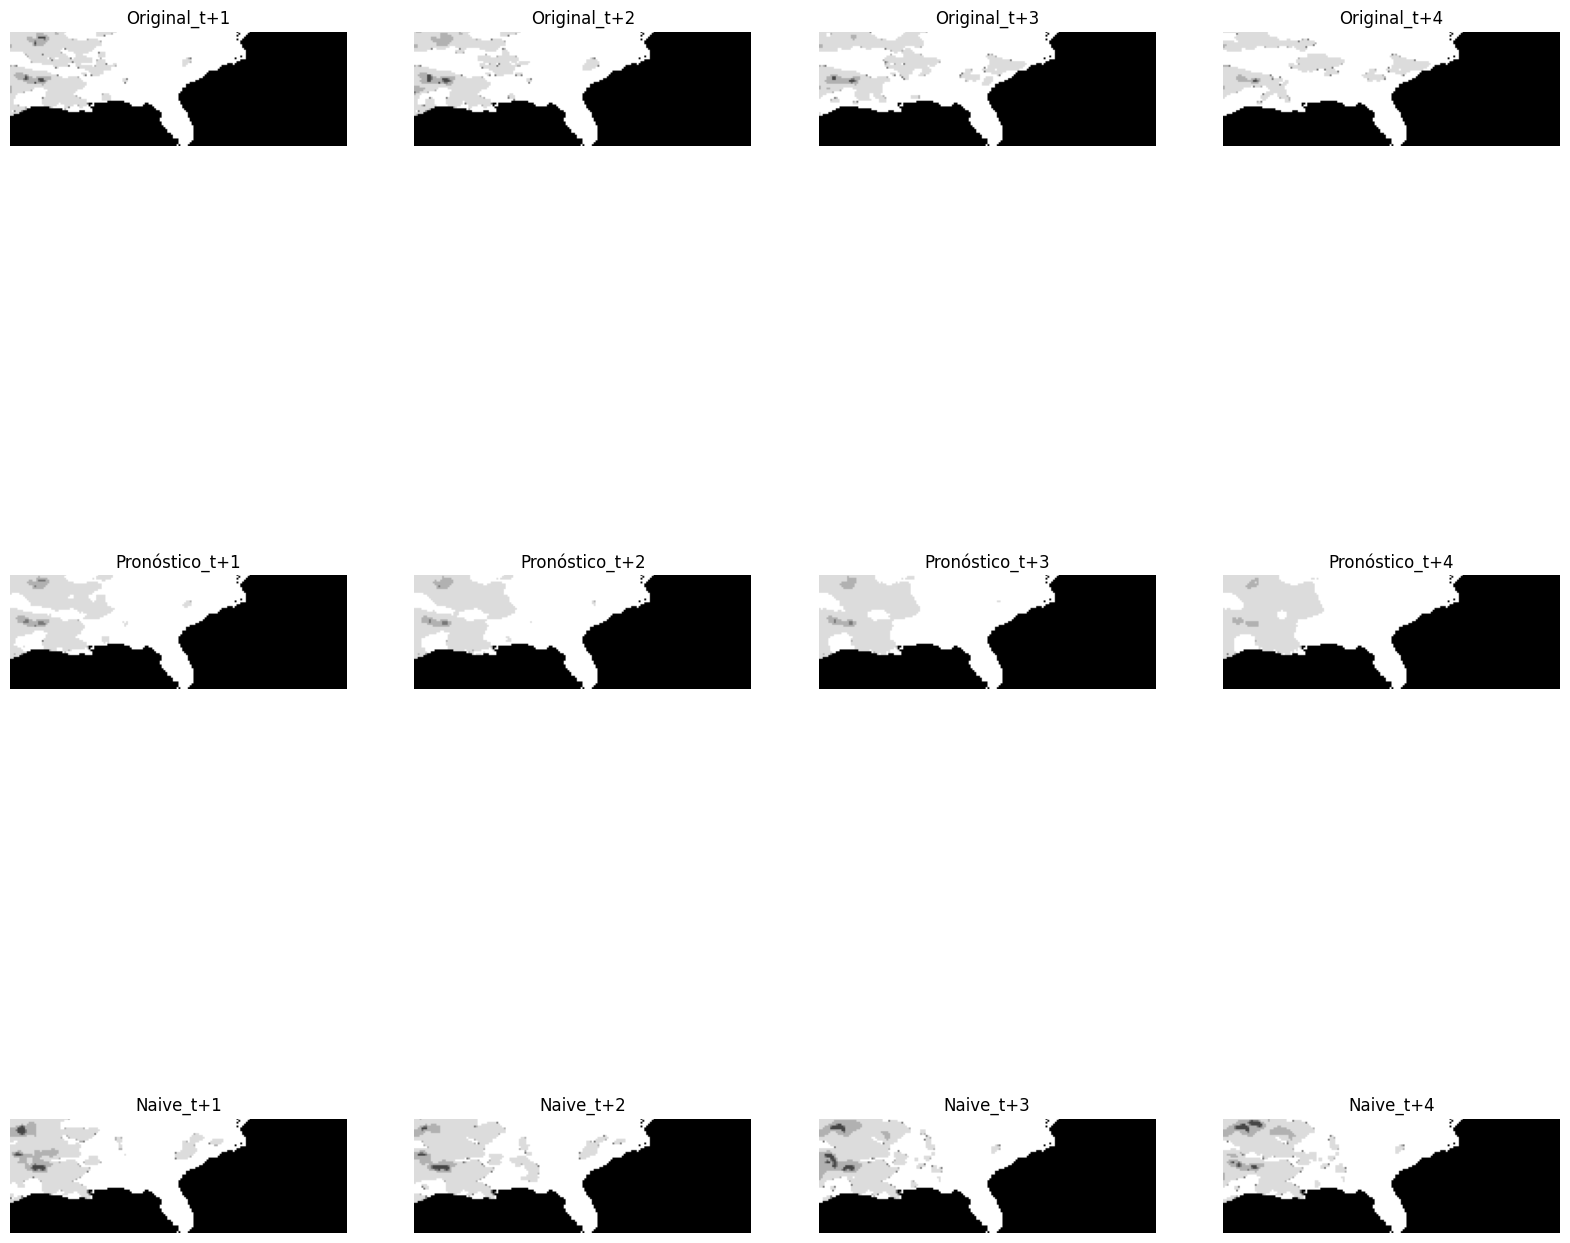

In [50]:

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 103
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

In [37]:
#print 
print (f"lengeth x_test: {y_test.shape[0]}")
print (f"h: {h}")
print (f"rows: {rows}")
print (f"cols: {cols}")

lengeth x_test: 367
h: 4
rows: 61
cols: 180


In [38]:
cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [39]:
for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            for j in range(cols):
                #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

Matriz de confusión de pronóstico
[[9257184       0       0       0       0       0      24]
 [     19 4215574  369386    5901     908      86      30]
 [      2  335502 1466304   51900    6908    1297      18]
 [      3   13369  106929  136097   14141    4322      84]
 [     25    8525   14912   11514   12566     966      93]
 [      4      10    4625   12815   25183   22534     738]
 [      7       3      86     577    2800    9320    5349]]
Matriz de confusión de naive
[[9257208       0       0       0       0       0       0]
 [      0 3889639  640147   43051   17308    1728      31]
 [      0  668574 1045227  119415   11822   16085     808]
 [      0   30362  138973   82825    4682   16085    2018]
 [      0   15957   13882    5092   10788    2492     390]
 [      0     462   18959   20798    2308   18710    4672]
 [      0      16     778    3059     883    6527    6879]]


In [40]:
#guardar matrices de confusión en un excel
import pandas as pd
df = pd.DataFrame(cm_f)
df.to_excel("DroughtDatasetMask/NPY61_180"+parte+"/ConfusionMatrixConvLSTM_forecast_61_180_"+parte+"_w5.xlsx", index=False)
df = pd.DataFrame(cm_n)
df.to_excel("DroughtDatasetMask/NPY61_180"+parte+"/ConfusionMatrixConvLSTM_naive_61_180_"+parte+"_w5.xlsx", index=False)

#calcular el accuracy
acc_f = 0
acc_n = 0
for i in range(l_clas):
    acc_f += cm_f[i,i]
    acc_n += cm_n[i,i]

acc_f = acc_f / (y_test.shape[0] * h * rows * cols)
acc_n = acc_n / (y_test.shape[0] * h * rows * cols)
print("Accuracy de pronóstico")
print(acc_f)
print("Accuracy de naive")
print(acc_n)

#guardar accuracy en un excel
df = pd.DataFrame([acc_f])
df.to_excel("DroughtDatasetMask/NPY61_180"+parte+"/AccuracyConvLSTM_forecast_61_180_"+parte+"_w5.xlsx", index=False)
df = pd.DataFrame([acc_n])
df.to_excel("DroughtDatasetMask/NPY61_180"+parte+"/AccuracyConvLSTM_naive_61_180_"+parte+"_w5.xlsx", index=False)

Accuracy de pronóstico
0.9377719212042703
Accuracy de naive
0.8878711851620236


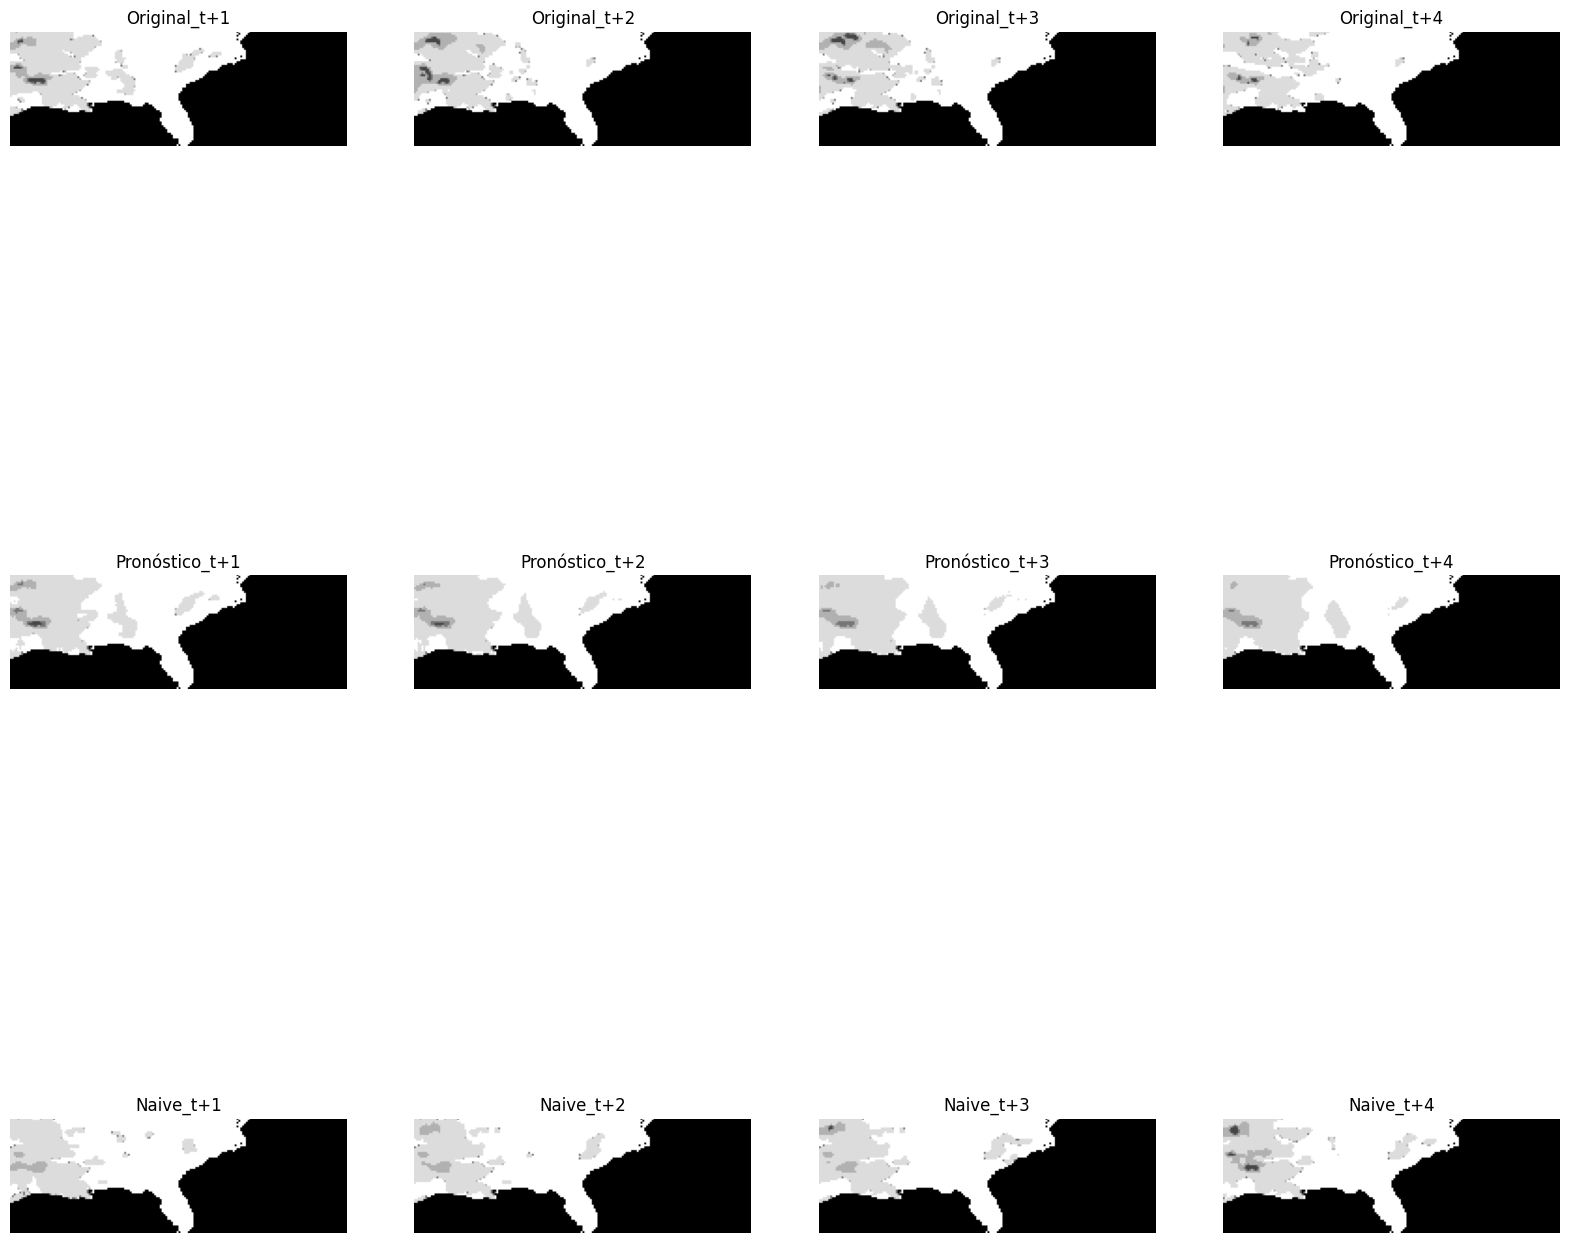

In [41]:
fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

## not working

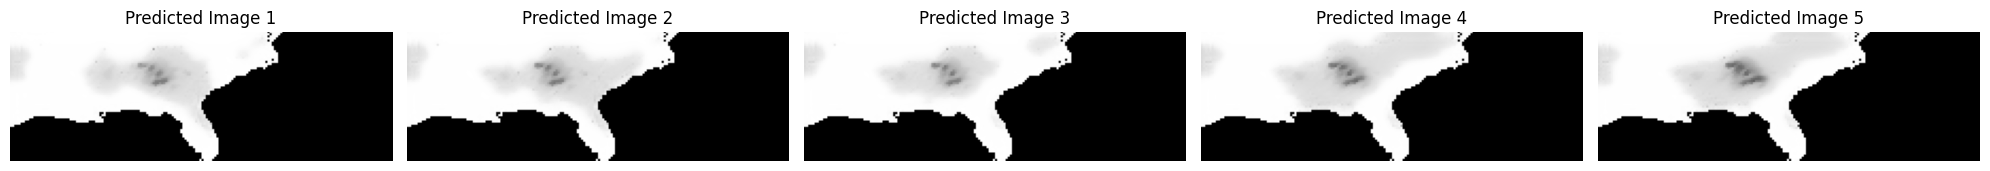

In [42]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    for j in range(len(modelos)):
        # Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
        axes[i].imshow(modelos[j][i].squeeze(), cmap='gray')
        axes[i].set_title(f"Predicted Image {i+1}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)


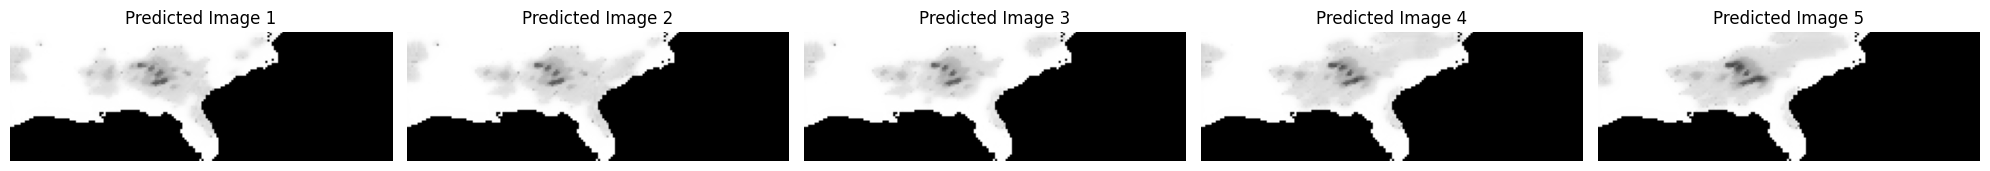

In [43]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    #Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
    print(f"Shape of predicted: {preds[i].shape}")
    axes[i].imshow(preds[i].squeeze(), cmap='gray')
    print(f"Shape of predicted image: {preds[i].shape}")
    axes[i].set_title(f"Predicted Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [44]:
print(range(len(x_test)))

range(0, 371)


In [45]:
#imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
#print(imagenInicial)

(4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 23ms/step


example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(1, 61, 180, 1)


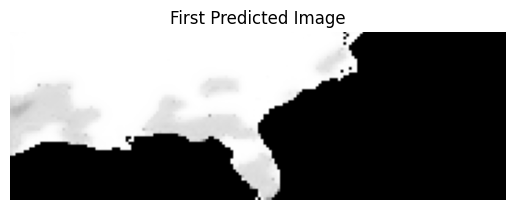

In [46]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()

(4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 23ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 21ms/step
example (4, 61, 180, 1)
(1, 61, 180, 1)


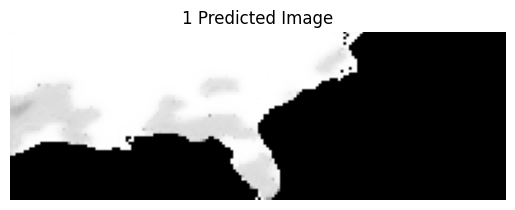

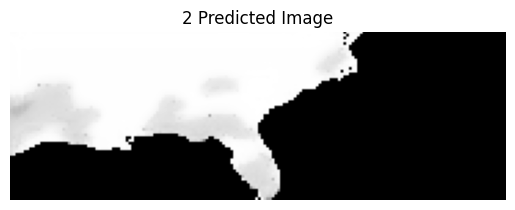

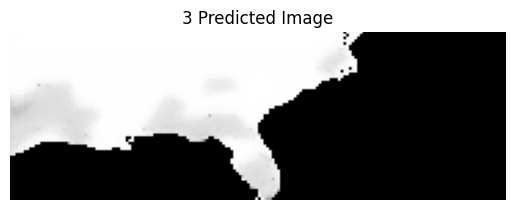

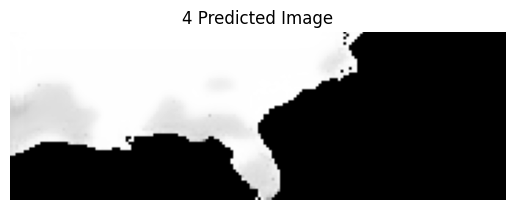

In [47]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()

for i in range(horizon):
    plt.imshow(example[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} Predicted Image")
    plt.axis('off')
    plt.show()

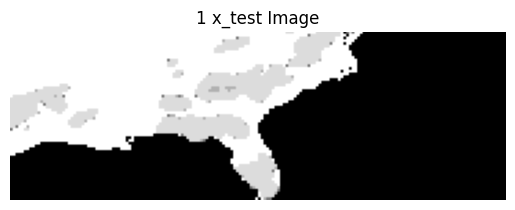

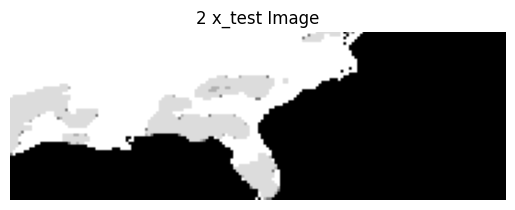

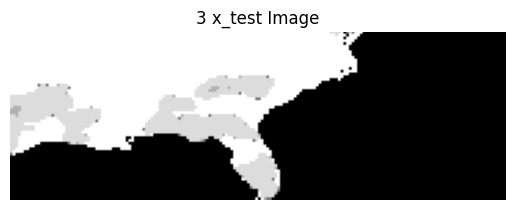

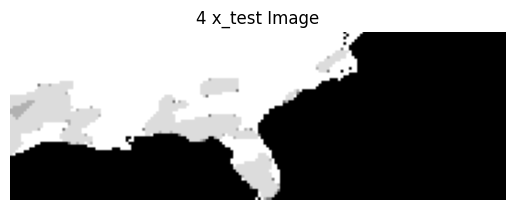

In [48]:
x_test = x_test[imagenInicial]
for i in range(horizon):
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} x_test Image")
    plt.axis('off')
    plt.show()